In [1]:
# %load /home/jonathan/.ipython/profile_default/startup/startup-01.py
# start up settings for ipython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

plt.style.use('ggplot')
plt.rcParams['font.size'] = 15.0
plt.rcParams['axes.labelsize'] = 15.0
plt.rcParams['xtick.labelsize'] = 15.0
plt.rcParams['ytick.labelsize'] = 15.0
plt.rcParams['legend.fontsize'] = 15.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000
# to avoid have warnings from chained assignments
pd.options.mode.chained_assignment = None


## Import results

In [12]:
# converter functions
def strip_str(text):
    try:
        text = (text + '').strip()
        if text == 'na':
            return np.nan
        else:
            return text
    except: 
        return text

    
def to_int(text):
    text = strip_str(text)
    try:
        # pandas cannot store nan as integer
        if pd.isnull(text):
            text = -1
        return int(text)
    except:
        return text
    
    
def to_float(text):
    text = strip_str(text)
    try:
        return float(text)
    except:
        return text
    

def to_bool(text):
    text = strip_str(text)
    try:
        return True if text == 'true' else False
    except:
        return text
    
converters = {
    'Model': strip_str, 'Log': strip_str, 
    'Iteration': to_int, 'NofTraceToAlign': to_int,
    'NofAlignmentValid': to_int, 'NofAlignmentOpen': to_int,
    'NofAlignmentRejected': to_int, 'NofLeftOutTraces': to_int,
    'NofSubnets': to_int, 'NofRecomposeActivities': to_int,
    'NofBorderActivities': to_int
}

# map from dirname to log strategy
def get_log_strategy(dirname):
    if dirname.endswith('L_exclude_S_M15'):
        log_strategy = 'SIC'
    elif dirname.endswith('L_group_S_M15'):
        log_strategy = 'IC'
    else:
        log_strategy = 'All'
    return log_strategy

# read from the different directories
iter_df_list = []

basedir = '../Final BPIC18 iterations/'
for dirname in os.listdir(basedir):
    log_strategy = get_log_strategy(dirname)
    filepath = os.path.join(basedir, dirname, 'stats.csv')
    iter_df = pd.read_csv(filepath, converters=converters)
    # add the log strategy
    iter_df['log_strategy'] = log_strategy
    iter_df['aligned_perc'] = iter_df[' NofAlignmentValid'] / iter_df[' NofTraceToAlign']
    iter_df_list.append(iter_df)

iter_df = pd.concat(iter_df_list)

## Plot results

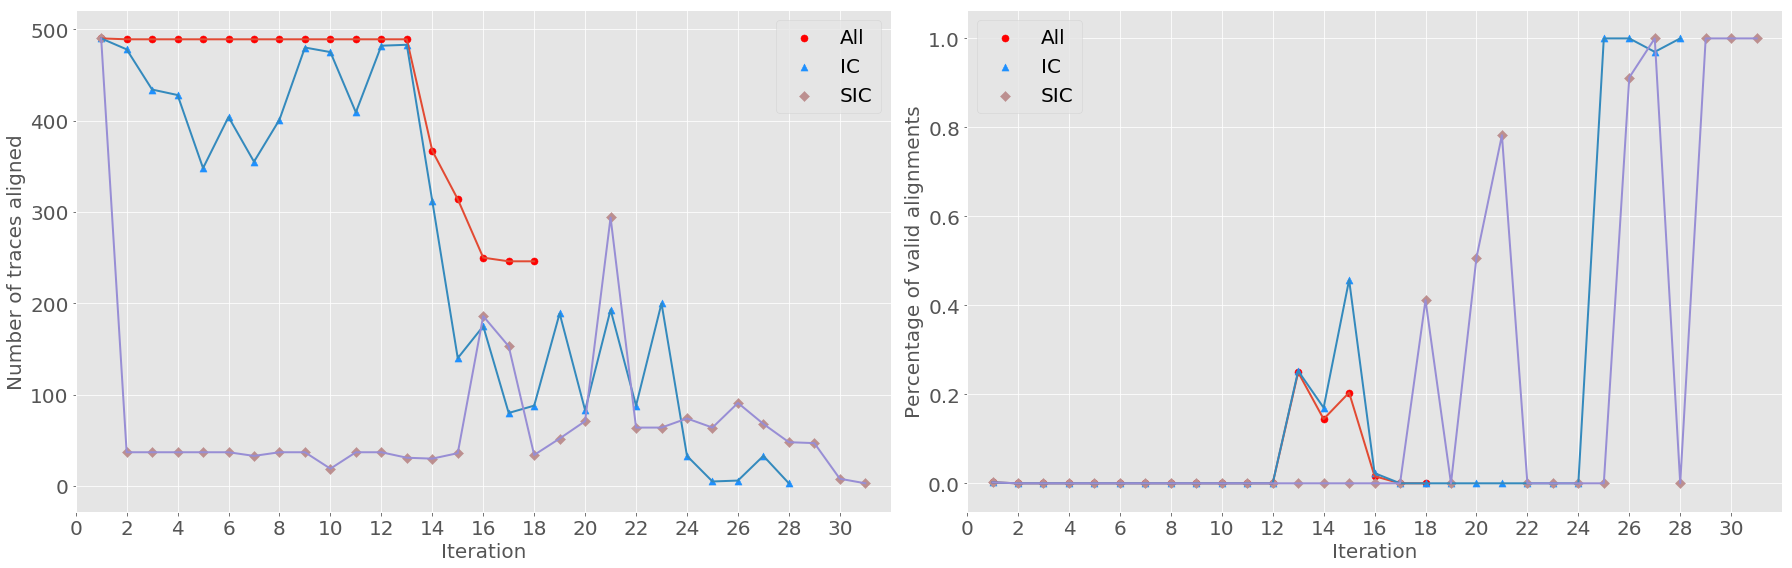

In [98]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 8))

colormap = {
    'All': 'r',
    'IC': 'dodgerblue',
    'SIC': 'rosybrown'
}

markermap = {
    'All': 'o',
    'IC': '^',
    'SIC': 'D'
}

markersize = 50

# plot the number of traces to align vs. iterations
ax0 = axes[0]
p_list = []

def plot_to_align(log_strategy, iter_df, ax, colormap, markermap, markersize):
    iter_df_strategy = iter_df[(iter_df['log_strategy'] == log_strategy)]
    to_align_strategy = iter_df_strategy[' NofTraceToAlign'].values
    iter_strategy = iter_df_strategy[' Iteration'].values
    pi = ax.scatter(x=iter_strategy, y=to_align_strategy, color=colormap[log_strategy], marker=markermap[log_strategy], s=markersize)
    ax.plot(iter_strategy, to_align_strategy, linewidth=2)
    p_list.append(pi)

for log_strategy in ['All', 'IC', 'SIC']:
    plot_to_align(log_strategy, iter_df, ax0, colormap, markermap, markersize)

ax0.legend(p_list, ['All', 'IC', 'SIC'], fontsize=20)
    
ax0.set_xlim([0, iter_df[' Iteration'].max() + 1])
xmin, xmax = ax0.get_xlim()
ax0.set_xticks(np.arange(xmin, xmax, 2))
ax0.set_ylabel('Number of traces aligned', fontsize=20)
ax0.set_xlabel('Iteration', fontsize=20)
ax0.tick_params(labelsize=20)

# plot the aligned percentage vs. iterations
ax1 = axes[1]
p_list = []

def plot_align_perc(log_strategy, iter_df, ax, colormap, markermap, markersize):
    iter_df_strategy = iter_df[(iter_df['log_strategy'] == log_strategy)]
    aligned_strategy = iter_df_strategy['aligned_perc'].values
    iter_strategy = iter_df_strategy[' Iteration'].values
    pi = ax.scatter(x=iter_strategy, y=aligned_strategy, color=colormap[log_strategy], marker=markermap[log_strategy], s=markersize)
    ax.plot(iter_strategy, aligned_strategy, linewidth=2)
    p_list.append(pi)
    
for log_strategy in ['All', 'IC', 'SIC']:
    plot_align_perc(log_strategy, iter_df, ax1, colormap, markermap, markersize)
    
ax1.legend(p_list, ['All', 'IC', 'SIC'], fontsize=20)

ax1.set_xlim([0, iter_df[' Iteration'].max() + 1])
xmin, xmax = ax1.get_xlim()
ax1.set_xticks(np.arange(xmin, xmax, 2))
ax1.set_ylabel('Percentage of valid alignments', fontsize=20)
ax1.set_xlabel('Iteration', fontsize=20)
ax1.tick_params(labelsize=20)
    
plt.tight_layout();

fig.savefig('./LogStrategy.jpg', bbox_inches='tight', dpi=500);